## Formula 1 placement predictions based on historical race data

Project for the Fundamentals of Machine Learning course.

The primary goal of this project is to predict the placement of drivers in a Formula 1 race based on historical race data. However, based on what other people have done in the past and based on my own intuition, I believe that predicting the exact placement is going to be quite inaccurate, so this project focuses on predicting whether a driver will finish in the top 3 (a podium finish) or not. After achieving this goal, I look into trying to predict the exact placement as a bonus.

Dancea Radu-Ioan

In [974]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#### Loading the data

We only load 3 relevant files. All of the other ones don't really contain information that is relevant for our objective. For example, **circuits.csv** contains the track names and geographical locations, which don't really influence driver performance. Other files, such as **lap_times.csv** could be useful, but past performance and qualifying positions tend to have a much higher impact on the final driver placement, so, for simplicity, such files are omitted.

In [ ]:
DATA_PATH = "data/"
YEAR_CUTOFF = 2005

results = pd.read_csv(DATA_PATH + "results.csv")
races = pd.read_csv(DATA_PATH + "races.csv")
qualifying = pd.read_csv(DATA_PATH + "qualifying.csv")

#### Preprocessing
There is a lot of information in the loaded files, a lot of which is not relevant to our objective. In the following cells these extra columns are eliminated and some extra features are added.

In [976]:
results = results[[
    "raceId",
    "driverId",
    "constructorId",
    "grid",
    "positionOrder"
]]

races = races[[
    "raceId",
    "year",
    "round",
]]

qualifying = qualifying[[
    "raceId",
    "driverId",
    "position"
]].rename(columns={"position": "qualifying_position"})

In [977]:
print(results.shape)
print(results.head())

print(races.shape)
print(races.head())

print(qualifying.shape)
print(qualifying.head())

(26759, 5)
   raceId  driverId  constructorId  grid  positionOrder
0      18         1              1     1              1
1      18         2              2     5              2
2      18         3              3     7              3
3      18         4              4    11              4
4      18         5              1     3              5
(1125, 3)
   raceId  year  round
0       1  2009      1
1       2  2009      2
2       3  2009      3
3       4  2009      4
4       5  2009      5
(10494, 3)
   raceId  driverId  qualifying_position
0      18         1                    1
1      18         9                    2
2      18         5                    3
3      18        13                    4
4      18         2                    5


The next cell adds the goal of this project: whether a driver will finish in the top 3 (1) or not (0)

In [978]:
results["top3"] = (results["positionOrder"] <= 3).astype(int)

The results are split across multiple dataframes, so we must merge them using the id columns. This is done so that we have the races, race results and the qualifying results all in the same frame.

In [979]:
df = results.merge(races, on="raceId", how="left")
df = df.merge(
    qualifying,
    on=["raceId", "driverId"],
    how="left"
)

print(df.shape)
df.head()

(26759, 9)


,raceId,driverId,constructorId,grid,positionOrder,top3,year,round,qualifying_position
0,18,1,1,1,1,1,2008,1,1.0
1,18,2,2,5,2,1,2008,1,5.0
2,18,3,3,7,3,1,2008,1,7.0
3,18,4,4,11,4,0,2008,1,12.0
4,18,5,1,3,5,0,2008,1,3.0


This cell eliminates all race information before YEAR_CUTOFF. I found this to improve results quite significantly, as older races were somewhat different, and quite a few of them have missing data.

In [980]:
df = df[df["year"] >= YEAR_CUTOFF].copy()

#### Data visualization

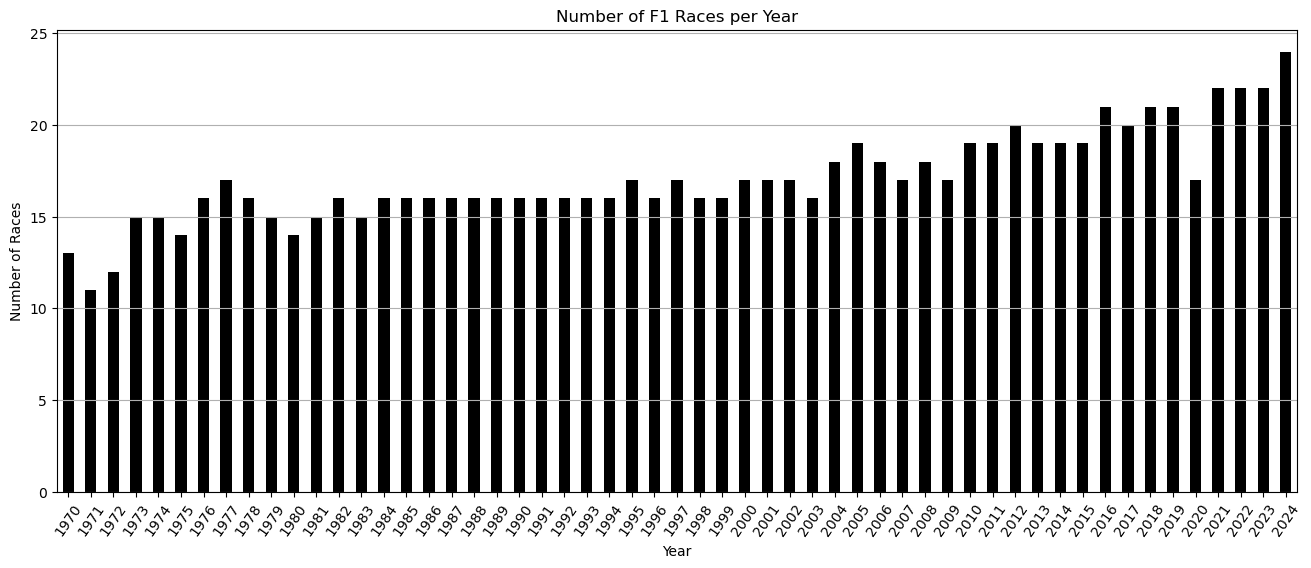

In [981]:
# Number of races per year, after YEAR_CUTOFF

races_per_year = df.groupby('year')['raceId'].nunique()

plt.figure(figsize=(16, 6))
races_per_year.plot(kind='bar', color='black')

plt.title('Number of F1 Races per Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.xticks(rotation = 55)
plt.grid(axis='y')

plt.show()

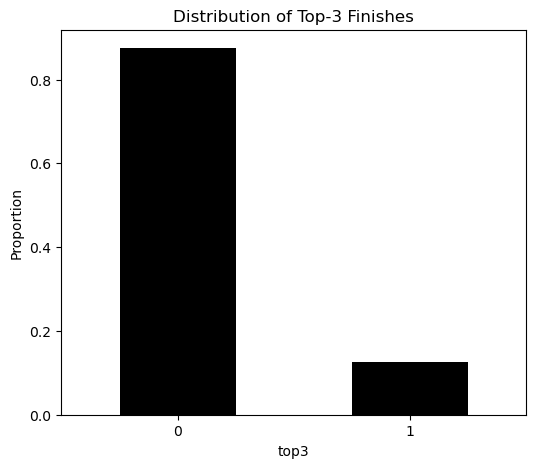

In [982]:
# Class imbalance visualization: distribution of top 3 finishes

top3_counts = df["top3"].value_counts(normalize=True)

plt.figure(figsize=(6, 5))
top3_counts.plot(kind="bar", color="black")

plt.title("Distribution of Top-3 Finishes")
plt.ylabel("Proportion")
plt.xticks(rotation=0)

plt.show()

The distribution of the top-3 target variable shows a clear class imbalance. As shown in  the previous cell, non-top-3 finishes account for a substantially larger proportion of the data, while top-3 finishes represent only a minority of observations. This imbalance reflects the inherent difficulty of achieving a podium finish and implies that a "dumb" classifier could achieve high accuracy by favoring the majority class. Consequently, evaluation metrics such as ROC AUC are more appropriate than accuracy, as they better capture the model’s ability to discriminate between the two classes under imbalanced conditions. This is why the conclusions of this project focus on ROC AUC rather than accuracy.

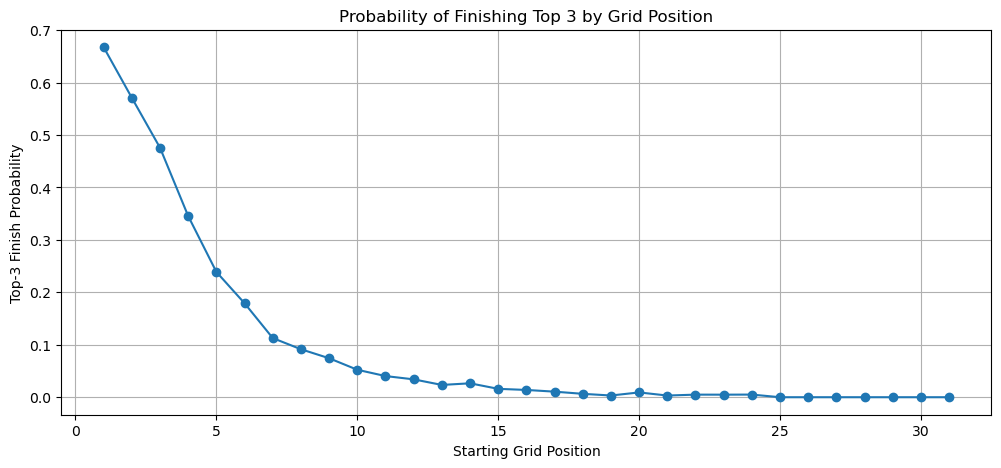

In [983]:
# Probability of finishing in the top 3 based on the starting grid position.

grid_top3_rate = df.groupby("grid")["top3"].mean()

grid_zero_rate = grid_top3_rate.loc[0]
grid_normal = grid_top3_rate.loc[grid_top3_rate.index > 0]

plt.figure(figsize=(12, 5))
grid_normal.plot(kind="line", marker="o")

plt.title("Probability of Finishing Top 3 by Grid Position")
plt.xlabel("Starting Grid Position")
plt.ylabel("Top-3 Finish Probability")
plt.grid()

plt.show()

#### Extra features

The problem with the features we have so far is that they don't show the driver's evolution throughout a season (or throughout their career). Previous races don't matter when predicting the result for the current race. In order to change this, we add a few features that represent the performance of the driver for the previous races in the season, and a few features that represent the driver's performance during last year's season.

Average driver finish for the previous races in the season.

In [984]:
df = df.sort_values(["year", "round"])

df["driver_avg_finish"] = (
    df.groupby(["year", "driverId"])["positionOrder"]
      .transform(lambda x: x.shift().expanding().mean())
)

# The average finish for Lewis Hamilton in 2019
grouped = df.groupby(["year", "driverId"])
print(grouped.get_group((2019, 1))[
    ["year", "round", "driverId", "positionOrder", "driver_avg_finish"]
])

print(df.shape)
df.tail(10)

       year  round  driverId  positionOrder  driver_avg_finish
24198  2019      1         1              2                NaN
24217  2019      2         1              1           2.000000
24237  2019      3         1              1           1.500000
24258  2019      4         1              2           1.333333
24277  2019      5         1              1           1.500000
24300  2019      6         1              1           1.400000
24320  2019      7         1              1           1.333333
24340  2019      8         1              1           1.285714
24364  2019      9         1              5           1.250000
24380  2019     10         1              1           1.666667
24408  2019     11         1              9           1.600000
24420  2019     12         1              1           2.272727
24441  2019     13         1              2           2.166667
24462  2019     14         1              3           2.153846
24483  2019     15         1              4           2

,raceId,driverId,constructorId,grid,positionOrder,top3,year,round,qualifying_position,driver_avg_finish
26749,1144,848,3,18,11,0,2024,24,16.0,14.695652
26750,1144,852,215,11,12,0,2024,24,11.0,13.217391
26751,1144,855,15,15,13,0,2024,24,17.0,15.608696
26752,1144,840,117,13,14,0,2024,24,13.0,13.347826
26753,1144,862,214,17,15,0,2024,24,20.0,NaN
26754,1144,825,210,14,16,0,2024,24,15.0,13.238095
26755,1144,859,215,12,17,0,2024,24,12.0,12.800000
26756,1144,822,15,9,18,0,2024,24,9.0,15.739130
26757,1144,861,3,20,19,0,2024,24,19.0,12.875000
26758,1144,815,9,10,20,0,2024,24,10.0,9.173913


Driver average finish in the previous season

In [985]:
prev_season = (
    df.groupby(["year", "driverId"])["positionOrder"]
      .mean()
      .reset_index()
)

prev_season["year"] += 1

df = df.merge(
    prev_season,
    on=["year", "driverId"],
    how="left",
    suffixes=("", "_prev_season_average")
)

Number of top 3 finishes for a driver in the current season, so far

In [986]:
df["driver_podiums_so_far"] = (
    df
    .groupby(["year", "driverId"])["top3"]
    .transform(lambda x: x.shift().cumsum())
)

Driver podium count in the previous season

In [987]:
prev_season_podiums = (
    df.groupby(["year", "driverId"])["top3"]
      .sum()
      .reset_index()
      .rename(columns={"top3": "driver_prev_season_podiums"})
)

prev_season_podiums["year"] += 1

df = df.merge(
    prev_season_podiums,
    on=["year", "driverId"],
    how="left"
)

Special feature that represents if a driver did not start from the normal grid (for example a pit start)

In [988]:
df["pit_lane_start"] = (df["grid"] == 0).astype(int)

In [989]:
print(df.shape)
df.tail(10)

(22639, 14)


,raceId,driverId,constructorId,grid,positionOrder,top3,year,round,qualifying_position,driver_avg_finish,positionOrder_prev_season_average,driver_podiums_so_far,driver_prev_season_podiums,pit_lane_start
22629,1144,848,3,18,11,0,2024,24,16.0,14.695652,12.409091,0.0,0.0,0
22630,1144,852,215,11,12,0,2024,24,11.0,13.217391,13.181818,0.0,0.0,0
22631,1144,855,15,15,13,0,2024,24,17.0,15.608696,14.045455,0.0,0.0,0
22632,1144,840,117,13,14,0,2024,24,13.0,13.347826,11.181818,0.0,0.0,0
22633,1144,862,214,17,15,0,2024,24,20.0,NaN,NaN,NaN,NaN,0
22634,1144,825,210,14,16,0,2024,24,15.0,13.238095,15.590909,0.0,0.0,0
22635,1144,859,215,12,17,0,2024,24,12.0,12.800000,12.200000,0.0,0.0,0
22636,1144,822,15,9,18,0,2024,24,9.0,15.739130,13.954545,0.0,0.0,0
22637,1144,861,3,20,19,0,2024,24,19.0,12.875000,NaN,0.0,NaN,0
22638,1144,815,9,10,20,0,2024,24,10.0,9.173913,5.863636,4.0,9.0,0


In [990]:
cols = [
    "grid",
    "positionOrder",
    "top3",
    "qualifying_position",
    "driver_avg_finish",
    "driver_podiums_so_far"
]

description = df[cols].describe()
selected_description = description.loc[["count", "mean", "std", "min", "max"]]

print(selected_description)

               grid  positionOrder          top3  qualifying_position  \
count  22639.000000   22639.000000  22639.000000         10494.000000   
mean      11.233579      12.933964      0.124696            11.195826   
std        7.165791       7.687177      0.330382             6.260374   
min        0.000000       1.000000      0.000000             1.000000   
max       31.000000      39.000000      1.000000            28.000000   

       driver_avg_finish  driver_podiums_so_far  
count       20846.000000           20846.000000  
mean           12.774818               1.093063  
std             5.611245               2.258997  
min             1.000000               0.000000  
max            39.000000              20.000000  


In the following cell, I show the correlation matrix for the numeric features. This matrix helps visualize how different numerical variables relate to each other and to the target variable **top3**.

One of the strongest relationships can be seen between grid position and qualifying position, which is expected since qualifying largely determines the starting grid. Both of these features also show a clear negative correlation with top3, meaning that drivers who start closer to the front of the grid are more likely to finish in the top three.

The matrix also shows that historical performance features are meaningful. For example, driver average finish and previous-season average finish both have a negative correlation with top3. This makes sense, as drivers who usually finish in better positions are more likely to achieve podium finishes. Similarly, previous-season podium count is positively correlated with top3, indicating that strong performance in past seasons often carries over into the current one.

Some features are clearly related to each other, such as driver average finish and previous-season average finish, which suggests a certain level of redundancy. However, these features capture performance over different time periods (current season vs previous season), so both were included.

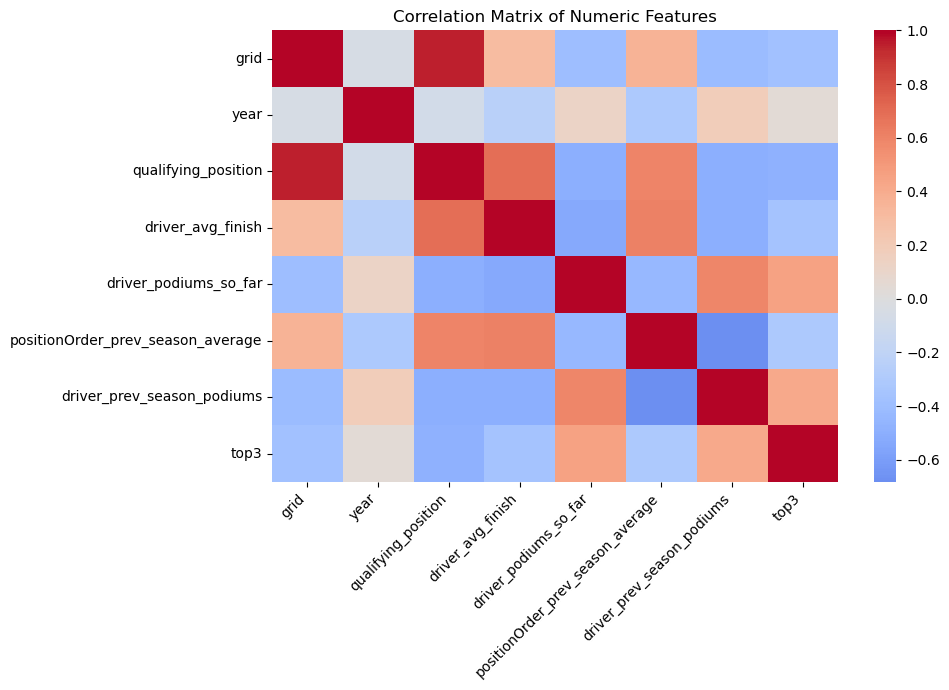

In [991]:
numeric_features = [
    "grid", 
    "year", 
    "qualifying_position", 
    "driver_avg_finish", 
    "driver_podiums_so_far",
    "positionOrder_prev_season_average",
    "driver_prev_season_podiums"
]
categorical_features = ["driverId", "constructorId"]

corr = df[numeric_features + ["top3"]].corr()

plt.figure(figsize=(10, 7))
matrix = sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    center=0
)
matrix.set_xticklabels(
    matrix.get_xticklabels(),
    rotation=45,
    ha="right"
)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

#### Pipelines and data transformations

Before training the models, the data needs to be prepared in a way that all algorithms can work with it reliably. Since the dataset contains both numerical and categorical features, different preprocessing steps are required for each type.

Categorical features such as the driver and constructor identifiers cannot be used directly by most machine learning models, because the numerical values themselves have no meaningful order. For this reason, one-hot encoding is applied. This converts each categorical value into a binary feature, allowing the models to distinguish between different drivers and teams without assuming any numerical relationship between them. The handle_unknown="ignore" option ensures that the model does not fail if it encounters categories in the test set that were not present during training.

Numerical features require a different treatment. Some of these variables contain missing values, especially for early-season races or drivers with limited history. These missing values are handled using median imputation, which is a robust choice that is less sensitive to extreme values than the mean. After imputation, numerical features are scaled using standardization so that they all have comparable ranges. This is particularly important for models such as Logistic Regression and Support Vector Machines, which are sensitive to the scale of the features.

In [992]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [993]:
# We drop the top3 column from X (because that represents our goal), but also positionOrder (to prevent data leakage).
drop_cols = ["top3", "positionOrder"]
X = df.drop(columns=drop_cols)
y = df["top3"]

seasons = sorted(df["year"].unique())
n_seasons = len(seasons)

train_end = int(n_seasons * 0.70)
val_end   = int(n_seasons * 0.85)

train_years = seasons[:train_end]
val_years   = seasons[train_end:val_end]
test_years  = seasons[val_end:]

train_df = df[df["year"].isin(train_years)].copy()
val_df   = df[df["year"].isin(val_years)].copy()
test_df  = df[df["year"].isin(test_years)].copy()

X_train = train_df.drop(columns=drop_cols)
y_train = train_df["top3"]

X_val = val_df.drop(columns=drop_cols)
y_val = val_df["top3"]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df["top3"]

print("YEAR_CUTOFF:", YEAR_CUTOFF)
print("Train years:", train_years)
print("Val years:  ", val_years)
print("Test years: ", test_years)

print("\nShapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

YEAR_CUTOFF: 1970
Train years: [np.int64(1970), np.int64(1971), np.int64(1972), np.int64(1973), np.int64(1974), np.int64(1975), np.int64(1976), np.int64(1977), np.int64(1978), np.int64(1979), np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007)]
Val years:   [np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015)]
Test years:  [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Shapes:
Train: (15495, 12) (15495,)
Val:   (3303, 12) (3303

#### Model selection and hyperparameter tuning

Several different models were trained and compared in order to better understand how model choice affects performance on this dataset. Instead of selecting a model based on a single train–test split, a validation set was used to compare models.

For each model, hyperparameters were tuned using cross-validation on the training data, with ROC-AUC as the main selection metric. ROC-AUC was chosen because the target variable (top-three finish) is highly imbalanced, making accuracy alone misleading. This metric better reflects how well a model can separate podium finishes from non-podium finishes across different decision thresholds.

After tuning, each model was evaluated on the validation set using the same metric. This step allowed a direct comparison of models under identical conditions, without using the test set. The final model was selected based on validation ROC-AUC, as this provides a better estimate of how the model is expected to perform on unseen future seasons.

In [994]:
models_and_params = {
    "LogisticRegression": (
        LogisticRegression(max_iter=5000),
        {
            "model__C": [0.01, 0.1, 1, 10],
            "model__class_weight": [None, "balanced"],
        }
    ),
    "LinearSVC": (
        LinearSVC(max_iter=5000),
        {
            "model__C": [0.01, 0.1, 1, 10],
            "model__class_weight": [None, "balanced"],
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            "model__max_depth": [3, 5, 10, None],
            "model__min_samples_leaf": [10, 50, 100],
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "model__n_estimators": [200, 500],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_leaf": [5, 20, 50],
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [2, 3],
        }
    ),
}

In [995]:
results = []

best_models = {}

for name, (model, params) in models_and_params.items():
    print(f"\n=== Tuning {name} ===")

    pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    search = GridSearchCV(
        pipeline,
        param_grid=params,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_

    # Validation set evaluation
    if hasattr(best_models[name].named_steps["model"], "predict_proba"):
        y_val_score = best_models[name].predict_proba(X_val)[:, 1]
    else:
        y_val_score = best_models[name].decision_function(X_val)

    validation_auc = roc_auc_score(y_val, y_val_score)

    # Also compute the accuracy for comparison purposes
    y_val_pred = best_models[name].predict(X_val)
    validation_accuracy = accuracy_score(y_val, y_val_pred)

    print("Best params:", search.best_params_)
    print("Best ROC-AUC during tuning:", round(search.best_score_, 4))
    print("Validation ROC-AUC:", round(validation_auc, 4))
    print("Validation accuracy:", round(validation_accuracy, 4))

    results.append({
        "model": name,
        "tuning_best_auc": search.best_score_,
        "validation_auc": validation_auc,
        "validation_accuracy": validation_accuracy,
        "best_params": search.best_params_
    })


=== Tuning LogisticRegression ===
Best params: {'model__C': 0.01, 'model__class_weight': 'balanced'}
Best ROC-AUC during tuning: 0.8882
Validation ROC-AUC: 0.9149
Validation accuracy: 0.8162

=== Tuning LinearSVC ===
Best params: {'model__C': 0.01, 'model__class_weight': 'balanced'}
Best ROC-AUC during tuning: 0.8853
Validation ROC-AUC: 0.8871
Validation accuracy: 0.8177

=== Tuning DecisionTree ===
Best params: {'model__max_depth': 5, 'model__min_samples_leaf': 100}
Best ROC-AUC during tuning: 0.8938
Validation ROC-AUC: 0.9168
Validation accuracy: 0.8995

=== Tuning RandomForest ===
Best params: {'model__max_depth': None, 'model__min_samples_leaf': 20, 'model__n_estimators': 500}
Best ROC-AUC during tuning: 0.8902
Validation ROC-AUC: 0.9212
Validation accuracy: 0.8704

=== Tuning GradientBoosting ===
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 100}
Best ROC-AUC during tuning: 0.8983
Validation ROC-AUC: 0.9215
Validation accuracy: 0.9001


In [996]:
summary = pd.DataFrame(results).sort_values("validation_auc", ascending=False)
print("\n================================= Summary =================================\n")
print(summary[["model", "tuning_best_auc", "validation_auc", "validation_accuracy"]])


================================= Summary =================================

                model  tuning_best_auc  validation_auc  validation_accuracy
4    GradientBoosting         0.898342        0.921524             0.900091
3        RandomForest         0.890245        0.921163             0.870421
2        DecisionTree         0.893758        0.916799             0.899485
0  LogisticRegression         0.888165        0.914858             0.816228
1           LinearSVC         0.885279        0.887083             0.817741


In [997]:
best_name = summary.iloc[0]["model"]
best_model = best_models[best_name]

if hasattr(best_model.named_steps["model"], "predict_proba"):
    y_test_score = best_model.predict_proba(X_test)[:, 1]
else:
    y_test_score = best_model.decision_function(X_test)

test_auc = roc_auc_score(y_test, y_test_score)
test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)

print(f"\nBEST MODEL: {best_name}")
print("Test ROC-AUC:", round(test_auc, 4))
print("Test accuracy:", round(test_acc, 4))
print(classification_report(y_test, test_pred))


BEST MODEL: GradientBoosting
Test ROC-AUC: 0.936
Test accuracy: 0.9047
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3271
           1       0.71      0.61      0.65       570

    accuracy                           0.90      3841
   macro avg       0.82      0.78      0.80      3841
weighted avg       0.90      0.90      0.90      3841



#### Conclusions for the top-3 objective

The coefficients of a Logistic Regression model show how each feature influences the predicted probability of a top-three finish. A positive coefficient means that increasing the value of that feature increases the likelihood of finishing in the top three, while a negative coefficient decreases it. The magnitude of the coefficient reflects how strong this effect is. In our case we can see that increasing the starting grid position significantly lowers a driver's chances of reaching the podium.

In [998]:
logreg = best_models["LogisticRegression"]

feature_names = (
    logreg.named_steps["preprocess"]
    .get_feature_names_out()
)

coefs = logreg.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values("coefficient", key=np.abs, ascending=False)

coef_df.head(15)

,feature,coefficient
0,num__grid,-1.039470
373,cat__constructorId_6,0.585192
3,num__driver_avg_finish,-0.533914
368,cat__constructorId_1,0.529422
370,cat__constructorId_3,0.512123
388,cat__constructorId_22,0.388390
6,num__driver_prev_season_podiums,0.268934
1,num__year,-0.238216
172,cat__driverId_172,0.235774
4,num__driver_podiums_so_far,0.233515


The SVM decision scores represent the distance of each sample from the separating hyperplane. Positive scores indicate predictions leaning toward a top-three finish, while negative scores indicate non-podium finishes. The further a point is from zero, the more confident the model is in its prediction.

Plotting the distribution of decision scores for both classes shows how well the model separates podium and non-podium finishes. Even if accuracy is lower, strong separation between the distributions explains why the ROC-AUC score can still be high.

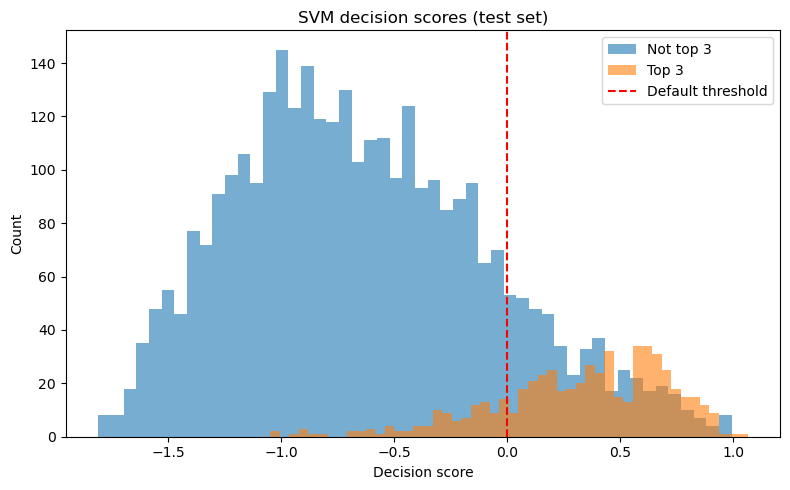

In [999]:
best_svm = best_models["LinearSVC"]
y_score_svm = best_svm.decision_function(X_test)

scores = y_score_svm

plt.figure(figsize=(8, 5))

plt.hist(scores[y_test == 0], bins=50, alpha=0.6, label="Not top 3")
plt.hist(scores[y_test == 1], bins=50, alpha=0.6, label="Top 3")

plt.axvline(0, color="red", linestyle="--", label="Default threshold")

plt.legend()
plt.title("SVM decision scores (test set)")
plt.xlabel("Decision score")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


Feature importance in a Decision Tree reflects how often and how effectively each feature is used to split the data when building the tree. Features that reduce impurity the most across splits receive higher importance values. In this case, we can see that the number of podiums a driver has achieved so far in the season is given the most importance.

In [1000]:
dt = best_models["DecisionTree"]

importances = dt.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

importance_df.head(10)

,feature,importance
4,num__driver_podiums_so_far,0.498231
0,num__grid,0.349724
6,num__driver_prev_season_podiums,0.110394
3,num__driver_avg_finish,0.018338
1,num__year,0.016581
5,num__positionOrder_prev_season_average,0.006475
370,cat__constructorId_3,0.000258
9,cat__driverId_3,0.000000
10,cat__driverId_4,0.000000
11,cat__driverId_5,0.000000


In a Random Forest, feature importance is computed by averaging the importance of each feature across many decision trees.

In [1001]:
rf = best_models["RandomForest"]

rf_importances = rf.named_steps["model"].feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

rf_importance_df.head(10)

,feature,importance
4,num__driver_podiums_so_far,0.184031
0,num__grid,0.183471
6,num__driver_prev_season_podiums,0.135262
3,num__driver_avg_finish,0.120493
5,num__positionOrder_prev_season_average,0.084208
2,num__qualifying_position,0.060719
373,cat__constructorId_6,0.047356
368,cat__constructorId_1,0.028121
34,cat__driverId_30,0.024758
370,cat__constructorId_3,0.018505


Gradient Boosting feature importance shows how much each feature contributes to reducing prediction errors as trees are added sequentially. Features that consistently help correct mistakes made by earlier trees receive higher importance.

In [1002]:
gb = best_models["GradientBoosting"]

gb_importances = gb.named_steps["model"].feature_importances_

comparison = pd.DataFrame({
    "feature": feature_names,
    "RF_importance": rf_importances,
    "GB_importance": gb_importances
}).sort_values("GB_importance", ascending=False)

comparison.head(10)

,feature,RF_importance,GB_importance
0,num__grid,0.183471,0.487944
4,num__driver_podiums_so_far,0.184031,0.253184
6,num__driver_prev_season_podiums,0.135262,0.148659
3,num__driver_avg_finish,0.120493,0.054771
2,num__qualifying_position,0.060719,0.019280
373,cat__constructorId_6,0.047356,0.009917
368,cat__constructorId_1,0.028121,0.007697
1,num__year,0.015796,0.006713
120,cat__driverId_117,0.014101,0.003025
370,cat__constructorId_3,0.018505,0.002004


##### ROC AUC Scores over multiple tests and iterations

For this project, Gradient Boosting seems to be the best model. Gradient Boosting tends to perform best because it builds the model step by step, with each new tree focusing specifically on the mistakes made by the previous ones. This allows the model to capture subtle patterns and interactions between features, such as how grid position, driver history, and constructor strength combine to influence podium finishes. Unlike a single decision tree, boosting reduces both underfitting and overfitting by using many small, focused trees, which leads to stronger overall predictions.

That being said, before reaching this final result (found in the current version of the notebook) I tried different things (no extra features, no cutoff year, etc.), tests which are included in the following table. This table contains the validation ROC-AUC score and the accuracy (**AUC-ROC / accuracy**)

| Model               | Baseline       | Avg Finish + Podiums | Prev features + Past year | Prev features + Cutoff year |
|---------------------|----------------|----------------------|---------------------------|-----------------------------|
| Logistic Regression | 0.876 / 0.835  | 0.913 / 0.789        | 0.913 / 0.794             | 0.914 / 0.816               |
| Linear SVC          | 0.869 / 0.830  | 0.901 / 0.823        | 0.907 / 0.883             | 0.887 / 0.817               |
| Decision Tree       | 0.901 / 0.893  | 0.907 / 0.897        | 0.909 / 0.897             | 0.916 / 0.899               |
| Random Forest       | 0.902 / 0.861  | 0.918 / 0.861        | 0.911 / 0.861             | 0.921 / 0.870               |
| Gradient Boosting   | 0.903 / 0.882  | 0.913 / 0.897        | 0.914 / 0.895             | 0.921 / 0.900               |

- **Baseline** includes the data with no extra features added.
- **Avg finish + Podiums** includes the two features which represent a driver's performance in the current season
- **Prev features + Past year** includes the previous two features (avg finish + podiums in the current season) + 2 features that summarize the driver's performance during the previous season
- **Prev features + Cutoff year** is the current and latest version of the project and includes all of the above (all 4 extra features) + a cutoff year set to 1970

##### Effect of cutoff year on Gradient Boosting performance

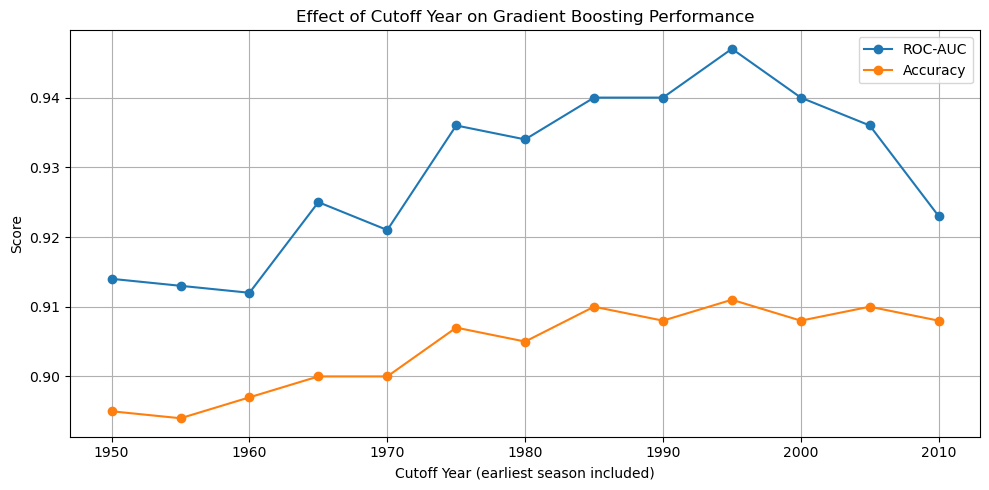

In [1003]:
# data gathered by trying all of these cutoff years in the current version of the notebook
data = {
    "cutoff_year": [1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010],
    "auc": [0.914, 0.913, 0.912, 0.925, 0.921, 0.936, 0.934, 0.940, 0.940, 0.947, 0.940, 0.936, 0.923],
    "accuracy": [0.895, 0.894, 0.897, 0.900, 0.900, 0.907, 0.905, 0.910, 0.908, 0.911, 0.908, 0.910, 0.908]
}

df_cutoff = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
plt.plot(df_cutoff["cutoff_year"], df_cutoff["auc"],
         marker="o", label="ROC-AUC")
plt.plot(df_cutoff["cutoff_year"], df_cutoff["accuracy"],
         marker="o", label="Accuracy")

plt.xlabel("Cutoff Year (earliest season included)")
plt.ylabel("Score")
plt.title("Effect of Cutoff Year on Gradient Boosting Performance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Bonus: exact placement prediction

In [ ]:
y_reg = df["positionOrder"]
X_reg = df.drop(columns=["positionOrder", "top3"])

X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

gbr_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        random_state=42
    ))
])

gbr_reg.fit(X_train, y_train)
y_pred = gbr_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Regression for exact placement prediction")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R^2:", round(r2, 3))

Gradient Boosting Regression (predict positionOrder)
MAE: 4.667
RMSE: 5.709
R^2: 0.45
